In [ ]:
# -*- coding: utf-8 -*-

## "Detection of Anomalies in Financial Transactions using Deep Autoencoder Networks"


The content of this "GPU Technology Conference (GTC) 2018, Silicon Valley" lab was jointly developed by Marco Schreyer and Timur Sattarov. Please don't hesitate to contact us in case of any questions via <a href="mailto:marco.schreyer@dfki.de">marco.schreyer@dfki.de</a> and <a href="mailto:sattarov.timur@pwc.com">sattarov.timur@pwc.com</a>.

## 1. Introduction and Lab Overview

### 1.1 Fraud and Accounting Information Systems (AIS)

The Association of Certified Fraud Examiners estimates in its Global Fraud Study 2016 [1] that the typical organization loses 5% of its annual revenues due to fraud. According to Joseph T. Wells [2] the term **"fraud"** refers to, 

>_"the abuse of one's occupation for personal enrichment through the deliberate misuse of an organization's resources or assets"_. 

A similar more recent study, conducted by the auditors of PwC, revealed that 30% of the study respondents experienced losses of between \$100,000 and \$5 million USD [3] in the last 24 months. The study also showed that financial statement fraud caused by far the greatest median loss of the surveyed fraud schemes.

At the same time organizations accelerate the digitization and reconfiguration of business processes [4] affecting in particular Accounting Information Systems (AIS) or more general Enterprise Resource Planning (ERP) systems.

<img align="middle" style="max-width: 550px; height: auto" src="images/accounting.png">

**Figure 1:** Hierarchical view of an Accounting Information System (AIS) that records distinct layers of abstraction, namely (1) the business process information, (2) the accounting information as well as the (3) technical journal entry information in designated database tables.

Steadily, these systems collect vast quantities of electronic evidence at an almost atomic level. This holds in particular for the journal entries of an organization recorded in its general ledger and sub-ledger accounts. SAP, one of the most prominent ERP software providers, estimates that approx. 76% of the world's transaction revenue touches one of their systems [5].

The illustration in **Figure 1** depicts a hierarchical view of an Accounting Information System (AIS) recording process and journal entry information in designated database tables. In the context of fraud examinations, the data collected by such systems may contain valuable traces of a potential fraud scheme.

### 1.2 Classification of Financial Anomalies

When conducting a detailed examination of real-world journal entries, usually recorded in large-scaled AIS or ERP systems, two prevalent characteristics can be observed:

> - specific transactions attributes exhibit **a high variety of distinct attribute values** e.g. customer information, posted sub-ledgers, amount information, and 
> - the transactions exhibit **strong dependencies between specific attribute values** e.g. between customer information and type of payment, posting type and general ledgers. 

Derived from this observation we distinguish two classes of anomalous journal entries, namely **"global"** and **"local" anomalies** as illustrated in **Figure 2** below:

<img align="middle" style="max-width: 450px; height: auto" src="images/anomalies.png">

**Figure 2:** Illustrative example of global and local anomalies portrait in a feature space of the two transaction features "Posting Amount" (Feature 1) and "Posting Positions" (Feature 2).

***Global Anomalies***, are financial transactions that exhibit **unusual or rare individual attribute values**. These anomalies usually relate to highly skewed attributes e.g. seldom posting users, rarely used ledgers, or unusual posting times. 

Traditionally "red-flag" tests, performed by auditors during annual audits, are designed to capture those types of anomalies. However, such tests might result in a high volume of false positive alerts due to e.g. regular reverse postings, provisions and year-end adjustments usually associated with a low fraud risk.

***Local Anomalies***, are financial transactions that exhibit an **unusual or rare combination of attribute values** while the individual attribute values occur quite frequently e.g. unusual accounting records. 

This type of anomaly is significantly more difficult to detect since perpetrators intend to disguise their activities trying to imitate a regular behaviour. As a result, such anomalies usually pose a high fraud risk since they might correspond to e.g. misused user accounts, irregular combinations of general ledger accounts and posting keys that don't follow an usual activity pattern.

### 1.3 Lab Objective and Prerequisites

The objective of this lab is to walk you through a deep learning based methodology that can be used to detect of global and local anomalies in financial datasets. The proposed method is based on the following assumptions: 

>1. the majority of financial transactions recorded within an organizations’ ERP-system relate to regular day-to-day business activities and perpetrators need to deviate from the ”regular” in order to conduct fraud,
>2. such deviating behaviour will be recorded by a very limited number of financial transactions and their respective attribute values or combination of attribute values and we refer to such deviation as "anomaly".

Concluding from these assumptions we can learn a model of regular journal entries with minimal ”harm” caused by the potential anomalous ones.

In order to detect such anomalies, we will train deep autoencoder networks to learn a compressed but "lossy" model of regular transactions and their underlying posting pattern. Imposing a strong regularization onto the network hidden layers limits the networks' ability to memorize the characteristics of anomalous journal entries. Once the training process is completed, the network will be able to reconstruct regular journal entries, while failing to do so for the anomalous ones.

After completing the lab you should be familiar with:

>1. the basic concepts, intuitions and major building blocks of autoencoder neural networks,
>2. the techniques of pre-processing financial data in order to learn a model of its characteristics,
>3. the application of autoencoder neural networks to detect anomalies in large-scale financial data, and,
>4. the interpretation of the detection results of the networks as well as its reconstruction loss. 

Please note, that this lab is neither a complete nor comprehensive forensic data analysis approach or fraud examination strategy. However, the methodology and code provided in this lab can be modified or adapted to detect anomalous records in a variety of financial datasets. Subsequently, the detected records might serve as a starting point for a more detailed and substantive examination by auditors or compliance personnel. 

For this lab, we assume that you are familiar with the general concepts of deep neural networks (DNN) and GPUs as well as PyTorch and Python. For more information on these concepts please check the relevant labs of NVIDIA's Deep Learning Institute (DLI). 

### Exercises: 

Think about potential fraud scenarios of your organization:

>1. What scenarios or fraudulent activities you could think of? [3 min]
>2. What data sources might affect or record those potential fraudulent activities? [5 min]
>3. What kind of data analytics techniques could be applied to detect those activities? [5 min]

## 2. Environment Setup and Verification

### 2.1 Python Verification

Before we begin, let's verify that Python is working on your system. To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Shift-Enter, or pressing the play button in the toolbar above. If all goes well, you should see some output returned below the grey cell.

In [1]:
print('The answer should be forty-two: {}'.format(str(40+2)))

The answer should be forty-two: 42


### 2.2 Python Libraries Import

As a next step let's import the libraries needed throughout the lab:

In [16]:
# importing utilities
import os
import sys
from datetime import datetime

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# import visualization libraries
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# from IPython.display import Image, display
sns.set_style('darkgrid')

# ignore potential warnings
import warnings
warnings.filterwarnings("ignore")

Allow for Jupyter notebook inline plotting:

In [3]:
%matplotlib inline

### 2.3 CUDNN and GPU Verification

To determine if CDNN is available on the server let's execute the cell below to display information about the available CUDNN version:

In [4]:
# print CUDNN backend version
now = datetime.now().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The CUDNN backend version: {}'.format(now, torch.backends.mps.is_available()))

[LOG 20240719-23:41:14] The CUDNN backend version: True


Also, let's display information about the potential GPUs running on the server:

In [4]:
!nvidia-smi

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/envs/aenn/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/0p/7c_yrf3d4j74ccb6yysm_tr80000gp/T/ipykernel_52142/1820151757.py", line 1, in <module>
    get_ipython().system('nvidia-smi')
  File "/opt/anaconda3/envs/aenn/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 657, in system_piped
  File "/opt/anaconda3/envs/aenn/lib/python3.12/site-packages/IPython/utils/_process_posix.py", line 125, in system
ModuleNotFoundError: No module named 'pexpect'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs/aenn/lib/python3.12/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/envs

If CUDNN and GPU's are available let's still specify if we want to use both:

In [5]:
USE_MPS = True

### 2.4 Python and PyTorch Verification

Let's execute the cell below to display information about the Python and PyTorch version running on the server:

In [6]:
# print current Python version
now = datetime.now().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The Python version: {}'.format(now, sys.version))

[LOG 20240719-23:41:20] The Python version: 3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 10:07:17) [Clang 14.0.6 ]


In [7]:
# print current PyTorch version
now = datetime.now().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] The PyTorch version: {}'.format(now, torch.__version__))

[LOG 20240719-23:41:20] The PyTorch version: 2.3.1


### 2.5 Random Seed Initialization

Finally, let' set the seeds of random elements in the code e.g. the initialization of the network parameters to guarantee deterministic computation and results:

In [8]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
if (torch.backends.mps.is_available()!= None and USE_MPS == True):
    torch.mps.manual_seed(seed_value) # set pytorch seed GPU

## 3. Financial Fraud Detection Dataset

In this section, we will conduct a descriptive analysis of the labs financial dataset. Furthermore, we will apply some necessary pre-processing steps to train a deep neural network. The lab is based on a derivation of the **"Synthetic Financial Dataset For Fraud Detection"** by Lopez-Rojas [6] available via the Kaggle predictive modelling and analytics competitions platform that can be obtained using the following link: https://www.kaggle.com/ntnu-testimon/paysim1.

Let's start loading the dataset and investigate its structure and attributes:

In [10]:
# load the dataset into the notebook kernel
ori_dataset = pd.read_parquet('./data/ML_data/input.parquet')

In [11]:
# inspect the datasets dimensionalities
now = datetime.now().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] Transactional dataset of {} rows and {} columns loaded'.format(now, ori_dataset.shape[0], ori_dataset.shape[1]))

[LOG 20240719-23:41:55] Transactional dataset of 2107826 rows and 10 columns loaded


### 3.1 Initial Data and Attribute Assessment

We augmented the dataset and renamed the attributes to appear more similar to a real-world dataset that one usually observes in SAP-ERP systems as part of SAP's Finance and Cost controlling (FICO) module. 

The dataset contains a subset of in total 7 categorical and 2 numerical attributes available in the FICO BKPF (containing the posted journal entry headers) and BSEG (containing the posted journal entry segments) tables. Please, find below a list of the individual attributes as well as a brief description of their respective semantics:

>- `BELNR`: the accounting document number,
>- `BUKRS`: the company code,
>- `BSCHL`: the posting key,
>- `HKONT`: the posted general ledger account,
>- `PRCTR`: the posted profit center,
>- `WAERS`: the currency key,
>- `KTOSL`: the general ledger account key,
>- `DMBTR`: the amount in local currency,
>- `WRBTR`: the amount in document currency.

Let's also have a closer look into the top 10 rows of the dataset:

In [12]:
# inspect top rows of dataset
ori_dataset.head(10) 

,BELNR,BSCHL,BUKRS,YEAR,HKONT_grouping,HKONT,WAERS,HKONT_text,WRBTR,DMBTR
0,100000000,50,IBE,2023,unlabelled,1143733,CHF,<NA>,0.00,0.01
1,100000000,40,IBE,2023,running_costs,6045011,CHF,Foreign exchange losses,0.00,0.01
2,100000002,40,IBE,2023,unlabelled,1143731,USD,<NA>,9586.94,9586.94
3,100000002,50,IBE,2023,unlabelled,1143731,USD,<NA>,9586.94,9586.94
4,100000010,40,IBE,2023,unlabelled,1143731,USD,<NA>,11584.66,11584.66
5,100000010,50,IBE,2023,unlabelled,1143731,USD,<NA>,11584.66,11584.66
6,100000011,40,IBE,2023,unlabelled,1143733,CHF,<NA>,0.00,35.27
7,100000011,50,IBE,2023,running_costs,7045011,CHF,Foreign exchange gains,0.00,35.27
8,100000013,40,IBE,2023,unlabelled,1143733,CHF,<NA>,0.00,1.02
9,100000013,50,IBE,2023,running_costs,7045011,CHF,Foreign exchange gains,0.00,1.02


You may also have noticed the attribute `label` in the data. We will use this field throughout the lab to evaluate the quality of our trained models. The field describes the true nature of each individual transaction of either being a **regular** transaction (denoted by `regular`) or an **anomaly** (denoted by `global` and `local`). Let's have closer look into the distribution of the regular vs. anomalous transactions in the dataset:

In [13]:
# number of anomalies vs. regular transactions
# ori_dataset.label.value_counts()

Ok, the statistic reveals that, similar to real world scenarios, we are facing a highly "unbalanced" dataset. Overall, the dataset contains only a small fraction of **100 (0.018%)** anomalous transactions. While the 100 anomalous entries encompass **70 (0.013%)** "global" anomalies and **30 (0.005%)** "local" anomalies as introduced in section 1.2.

In [14]:
# remove the "ground-truth" label information for the following steps of the lab
# label = ori_dataset.pop('label')

### 3.2 Pre-Processing of Categorical Transaction Attributes

From the initial data assessment above we can observe that the majority of attributes recorded in AIS- and ERP-systems correspond to categorical (discrete) attribute values, e.g. the posting date, the general-ledger account, the posting type, the currency. Let's have a more detailed look into the distribution of two dataset attributes, namely (1) the posting key `BSCHL` as well as (2) the general ledger account `HKONT`:

Text(0.5, 1.0, 'Distribution of HKONT attribute values')

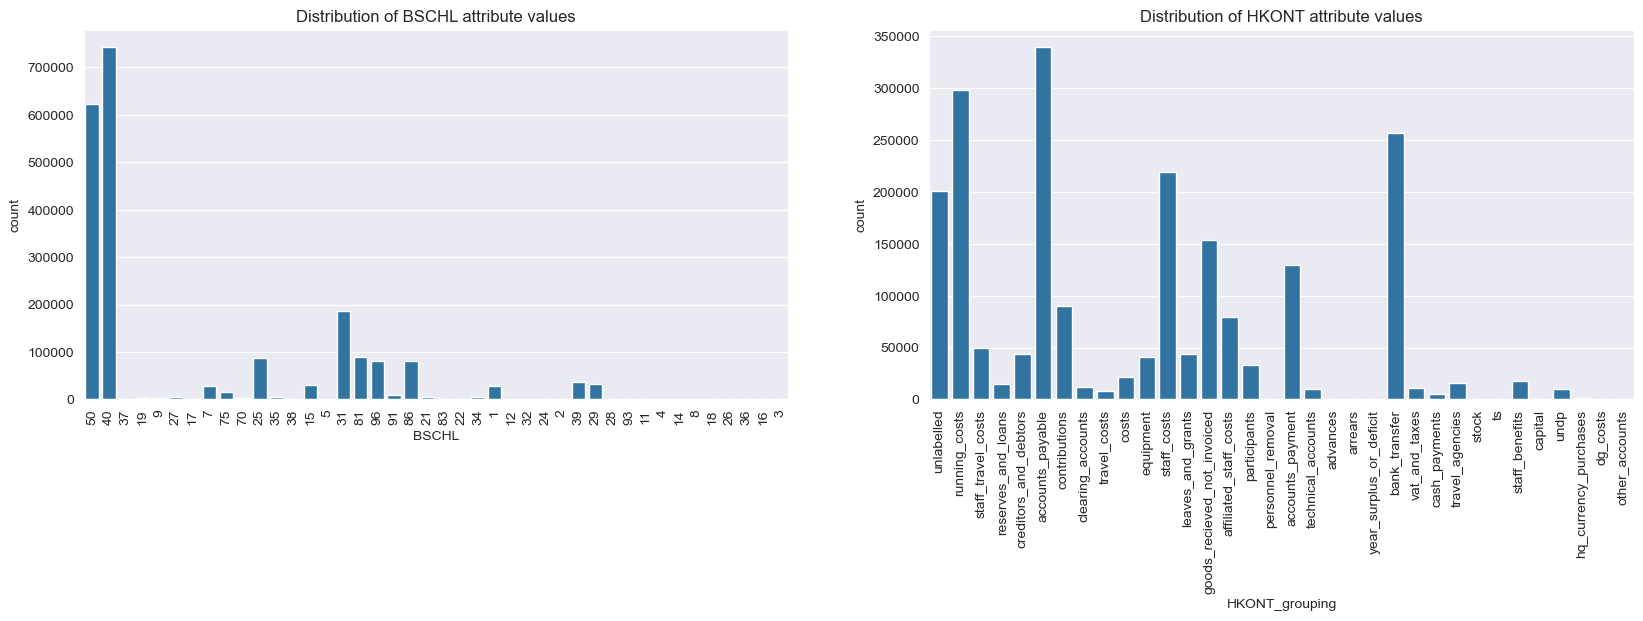

In [17]:
# prepare to plot posting key and general ledger account side by side
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot the distribution of the posting key attribute
g = sns.countplot(x=ori_dataset['BSCHL'], ax=ax[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of BSCHL attribute values')

# plot the distribution of the general ledger account attribute
g = sns.countplot(x=ori_dataset['HKONT_grouping'], ax=ax[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Distribution of HKONT attribute values')

Unfortunately, neural networks are in general not designed to be trained directly on categorical data and require the attributes to be trained on to be numeric. One simple way to meet this requirement is by applying a technique referred to as **"one-hot" encoding**. Using this encoding technique, we will derive a numerical representation of each of the categorical attribute values. One-hot encoding creates new binary columns for each categorical attribute value present in the original data. 

Let's work through a brief example: The **categorical attribute “Receiver”** below contains the names "John", "Timur" and "Marco". We "one-hot" encode the names by creating a separate binary column for each possible name value observable in the "Receiver" column. Now, we encode for each transaction that contains the value "John" in the "Receiver" column this observation with 1.0 in the newly created "John" column and 0.0 in all other created name columns.

<img align="middle" style="max-width: 430px; height: auto" src="images/encoding.png">

Using this technique will "one-hot" encode the 6 categorical attributes in the original transactional dataset. This can be achieved using the `get_dummies()` function available in the Pandas data science library:  

In [18]:
# select categorical attributes to be "one-hot" encoded
categorical_attr_names = ['BUKRS', 'BSCHL','HKONT_grouping','WAERS']

# encode categorical attributes into a binary one-hot encoded representation 
ori_dataset_categ_transformed = pd.get_dummies(ori_dataset[categorical_attr_names])

Finally, let's inspect the encoding of 10 sample transactions to see if we have been successfull.

### 3.2 Pre-Processing of Numerical Transaction Attributes

Let's now inspect the distributions of the two numerical attributes contained in the transactional dataset namely, the (1) local currency amount `DMBTR` and the (2) document currency amount `WRBTR`:

Text(0.5, 1.0, 'Distribution of WRBTR amount values')

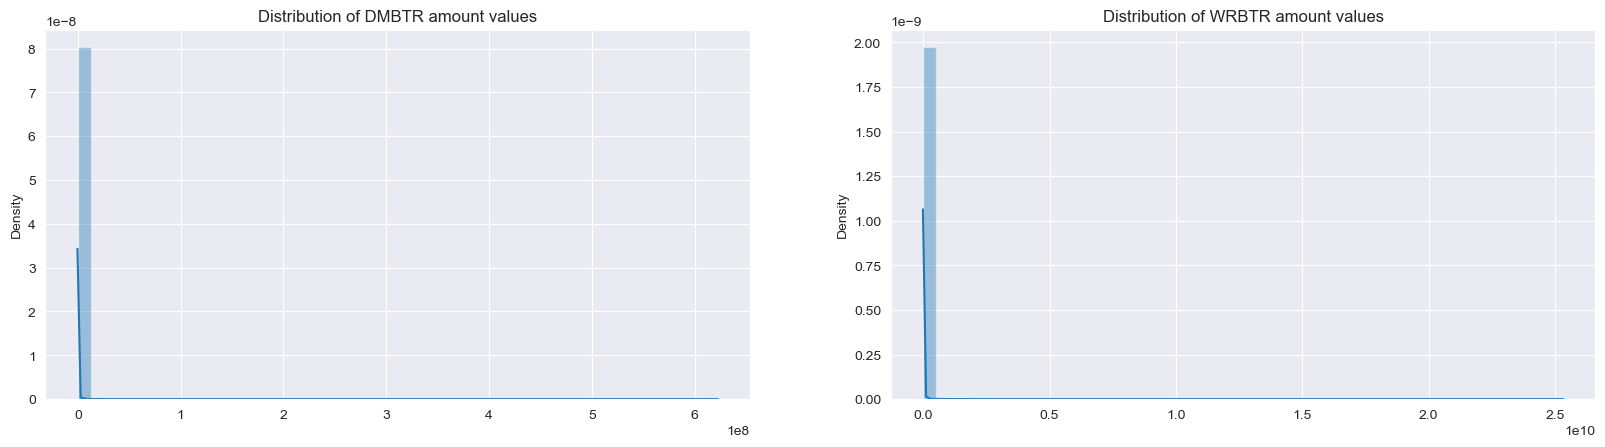

In [19]:
# plot the log-scaled "DMBTR" as well as the "WRBTR" attribute value distribution
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

head = 1000000

# plot distribution of the local amount attribute
g = sns.distplot(ori_dataset.sample(head)['DMBTR'].tolist(), ax=ax[0])
g.set_title('Distribution of DMBTR amount values')

# plot distribution of the document amount attribute
g = sns.distplot(ori_dataset.sample(head)['WRBTR'].tolist(), ax=ax[1])
g.set_title('Distribution of WRBTR amount values')

As expected, it can be observed, that for both attributes the distributions of amount values are heavy tailed. In order to approach faster a potential global minimum scaling and normalization of numerical input values is good a practice. Therefore, we first log-scale both variables and second min-max normalize the scaled amounts to the interval [0, 1].

In [20]:
# select "DMBTR" vs. "WRBTR" attribute
numeric_attr_names = ['DMBTR', 'WRBTR']

# add a small epsilon to eliminate zero values from data for log scaling
numeric_attr = ori_dataset[numeric_attr_names] + 1e-7
numeric_attr = numeric_attr.apply(np.log)

# normalize all numeric attributes to the range [0,1]
ori_dataset_numeric_attr = (numeric_attr - numeric_attr.min()) / (numeric_attr.max() - numeric_attr.min())

Let's now visualize the log-scaled and min-max normalized distributions of both attributes:

In [21]:
# append 'label' attribute for colour distinction
numeric_attr_vis = ori_dataset_numeric_attr.copy()
numeric_attr_vis['label'] = label

# plot the log-scaled and min-max normalized numeric attributes
g = sns.pairplot(data=numeric_attr_vis, vars=numeric_attr_names, hue='label')
g.fig.suptitle('Distribution of DMBTR vs. WRBTR amount values')
g.fig.set_size_inches(15, 5)

NameError: name 'label' is not defined

Ok, as anticipated the numeric attribute values of the "global" anomalies (green) fall outside the range of the regular amount distributions due to their unusual high amount values. In contrast, the numeric attribute values of the "local" anomalies (orange) are much more commingled within the regular transaction amounts.

### 3.3 Merge Categorical and Numerical Transaction Attributes

Finally, we merge both pre-processed numerical and categorical attributes into a single dataset that we will use for training our deep autoencoder neural network (explained an implemented in the following section 4.):

In [22]:
# merge categorical and numeric subsets
ori_subset_transformed = pd.concat([ori_dataset_categ_transformed, ori_dataset_numeric_attr], axis = 1)

Now, let's again have a look at the dimensionality of the dataset after we applied the distinct pre-processing steps to the attributes:

In [23]:
# inspect final dimensions of pre-processed transactional data
ori_subset_transformed.shape

(2107826, 202)

### Exercises: 

Following the pre-processing steps above you may have noticed, that we didn't encode the attributes `WAERS` and `BUKRS` yet. This we left as an exercise for you:

>1. Plot and inspect the distribution of the values of both attributes `WAERS` and `BUKRS`. [3 min]
>2. Encode both variables using the `get_dummies()` method provided by the Pandas library. [5 min]
>3. Merge your encoding results with the Pandas `ori_subset_transformed` data frame. [5 min]

Ok, upon completion of all the pre-processing steps (incl. the exercises) we should end up with an encoded dataset consisting of a total number of 533,009 records (rows) and **618 encoded attributes** (columns). Let's keep the number number of columns in mind since it will define the dimensionality of the input- and output-layer of our deep autoencoder network which we will now implement in the following section.

## 4. Autoencoder Neural Networks (AENNs)

The objective of this section is to familiarize ourselves with the underlying idea and concepts of building a deep autoencoder neural network (AENN). We will cover the major building blocks and the specific network structure of AENNs as well as an exemplary implementation using the open source machine learning library PyTorch.

### 4.1 Autoencoder Neural Network Architecture

AENNs or "Replicator Neural Networks" are a variant of general feed-forward neural networks that have been initially introduced by Hinton and Salakhutdinov in [6]. AENNs usually comprise a **symmetrical network architecture** as well as a central hidden layer, referred to as **"latent"** or **"coding" layer**, of lower dimensionality. The design is chosen intentionally since the training objective of an AENN is to reconstruct its input in a "self-supervised" manner. 

**Figure 3** below illustrates a schematic view of an autoencoder neural network:

<img align="middle" style="max-width: 600px; height: auto" src="images/autoencoder.png">

**Figure 3:** Schematic view of an autoencoder network comprised of two non-linear mappings (fully connected feed forward neural networks) referred to as encoder $f_\theta: \mathbb{R}^{dx} \mapsto \mathbb{R}^{dz}$ and decoder $g_\theta: \mathbb{R}^{dz} \mapsto \mathbb{R}^{dx}$.

Furthermore, AENNs can be interpreted as "lossy" data **compression algorithms**. They are "lossy" in a sense that the reconstructed outputs will be degraded compared to the original inputs. The difference between the original input $x^i$ and its reconstruction $\hat{x}^i$ is referred to as **reconstruction error**. In general, AENNs encompass three major building blocks:


>   1. an encoding mapping function $f_\theta$, 
>   2. a decoding mapping function $g_\theta$, 
>   3. and a loss function $\mathcal{L_{\theta}}$.

Most commonly the encoder and the decoder mapping functions consist of **several layers of neurons followed by a non-linear function** and shared parameters $\theta$. The encoder mapping $f_\theta(\cdot)$ maps an input vector (e.g. an "one-hot" encoded transaction) $x^i$ to a compressed representation $z^i$ referred to as latent space $Z$. This hidden representation $z^i$ is then mapped back by the decoder $g_\theta(\cdot)$ to a re-constructed vector $\hat{x}^i$ of the original input space (e.g. the re-constructed encoded transaction). Formally, the nonlinear mappings of the encoder- and the decoder-function can be defined by:

<center>$f_\theta(x^i) = s(Wx^i + b)$, and $g_\theta(z^i) = s′(W′z^i + d)$,</center>

where $s$ and $s′$ denote non-linear activations with model parameters $\theta = \{W, b, W', d\}$, $W \in \mathbb{R}^{d_x \times d_z}, W' \in \mathbb{R}^{d_z \times d_y}$ are weight matrices and $b \in \mathbb{R}^{dx}$, $d \in \mathbb{R}^{dz}$ are offset bias vectors.

### 4.2 Autoencoder Neural Network Implementation

Now, let's start implementing an AENN by first implementing the encoder network using PyTorch. For the encoder, we aim to implement a network consisting of **nine fully-connected layers**. Furthermore, the encoder is specified by the following number of neurons per layer: "618-256-128-64-32-16-8-4-3". Meaning the first layer consists of 618 neurons (specified by the dimensionality of our input data), the second layer of 256 neurons and the subsequent layers of 128, 64, 32, 16, 8, 4 and 3 neurons respectively.

Some elements of the encoder network code below should be given particular attention:

>- `self.encoder_Lx`: defines the linear transformation of the layer applied to the incoming input: $Wx + b$.
>- `nn.init.xavier_uniform`: inits the layer weights using a uniform distribution according to [9]. 
>- `self.encoder_Rx`: defines the non-linear transformation of the layer: $\sigma(\cdot)$.
>- `self.dropout`: randomly zeros some of the elements of the input tensor with probability $p$ according to [8].

We use **"Leaky ReLUs"** as introduced by Xu et al. in [7] to avoid "dying" non-linearities and to speed up training convergence. Leaky ReLUs allow a small gradient even when a particular neuron is not active. In addition, we include the **"drop-out" probability**, as introduced by [8], which defines the probability rate for each neuron to be set to zero at a forward pass to prevent the network from overfitting. However we explore its effect on the model later in the exercise section of the lab. Initially, we set the dropout probability of each neuron to $p=0.0$ (0%), meaning that none of the neuron activiations will be set to zero.

In [24]:
ori_subset_transformed.shape[1]

202

In [25]:
# implementation of the encoder network
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 512
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=512, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 512, out 256
        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform_(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 256, out 128
        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform_(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 128, out 64
        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform_(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 64, out 32
        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform_(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 32, out 16
        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform_(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 7 - in 16, out 8
        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform_(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 8, out 4
        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform_(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 4, out 3
        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform_(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x)) # don't apply dropout to the AE bottleneck

        return x

Now, we are ready to instantiate the encoder model to be trained on the CPU or to be trained on any of the available GPUs (if CUDNN is available and `USE_CUDA` is set to `True`) by execution of the following cell:

In [26]:
# init training network classes / architectures
encoder_train = encoder()

# push to cuda if cudnn is available
# if (torch.backends.mps.is_available()!= None and USE_MPS == True):
#     mps_device = torch.device("mps")
#     encoder_train.to(mps_device)

Once the model is initialized we can visualize the model structure and review the implemented network architecture by execution of the following cell:

In [27]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))

[LOG 20240719-21:43:55] encoder architecture:

encoder(
  (encoder_L1): Linear(in_features=202, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_feature

Looks, great? Excellent!

Let's, now as a next step, complete the AENN by implementing the corresponding decoder network. The decoder also consists of nine fully-connected layers. Futhermore, the decoder network is intended to **symmetrically mirror** the encoder networks architecture by a layer wise inversion "3-4-8-16-32-64-128-256-618" of the encoder network layers.

In [28]:
# implementation of the decoder network
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 4
        self.decoder_L1 = nn.Linear(in_features=3, out_features=4, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

        # specify layer 2 - in 4, out 8
        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform_(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 3 - in 8, out 16
        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform_(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 4 - in 16, out 32
        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform_(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 5 - in 32, out 64
        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform_(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 6 - in 64, out 128
        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform_(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)
        
        # specify layer 7 - in 128, out 256
        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform_(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 8 - in 256, out 512
        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform_(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # specify layer 9 - in 512, out 618
        self.decoder_L9 = nn.Linear(in_features=512, out_features=ori_subset_transformed.shape[1], bias=True)
        nn.init.xavier_uniform_(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # init dropout layer with probability p
        self.dropout = nn.Dropout(p=0.0, inplace=True)

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x)) # don't apply dropout to the AE output
        
        return x

Let's also instantiate the encoder model for CPU or GPU training and convince ourselves that it was successfully initialized by printing and reviewing its architecture by execution of the following cell:

In [29]:
# init training network classes / architectures
decoder_train = decoder()

# push to cuda if cudnn is available
# if (torch.backends.mps.is_available()!= None and USE_MPS == True):
#     mps_device = torch.device("mps")
#     decoder_train.to(mps_device)
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20240719-21:43:59] decoder architecture:

decoder(
  (decoder_L1): Linear(in_features=3, out_features=4, bias=True)
  (decoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L2): Linear(in_features=4, out_features=8, bias=True)
  (decoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L3): Linear(in_features=8, out_features=16, bias=True)
  (decoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L4): Linear(in_features=16, out_features=32, bias=True)
  (decoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L5): Linear(in_features=32, out_features=64, bias=True)
  (decoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L6): Linear(in_features=64, out_features=128, bias=True)
  (decoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L7): Linear(in_features=128, out_features=256, bias=True)
  (decoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (decoder_L8): Linear(in_features=256, out_features=512,

Looks like intended? Brilliant!

### 4.3 Autoencoder Neural Network Training

Now that we have implemented the AENN we are ready to train the network. Prior to starting the training, we need to define an apropriate loss function. Remember, we aim to train our model to learn a set of encoder-decoder model parameters $\theta$ that minimize the dissimilarity of a given financial transaction $x^{i}$ and its reconstruction $\hat{x}^{i} = g_\theta(f_\theta(x^{i}))$ as faithfully as possible. 

Thereby, the training objective is to learn a set of optimal shared encoder-decoder model parameters $\theta^*$ that optimize $\arg\min_{\theta} \|X - g_\theta(f_\theta(X))\|$ over all transactions or more specifically journal entries $X$. To achieve this optimization objective, one typically minimizes a loss function $\mathcal{L_{\theta}}$ as part of the network training. In this lab we use the **binary-cross-entropy error (BCE)** loss, defined by:

<center> $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i}) = \frac{1}{n}\sum_{i=1}^{n}\sum_{j=1}^{k} x^{i}_{j} ln(\hat{x}^{i}_{j}) + (1-x^{i}_{j}) ln(1-\hat{x}^{i}_{j})$, </center>

for a set of $n$-journal entries $x^{i}$, $i=1,...,n$ and their respective reconstructions $\hat{x}^{i}$ and all journal entry attributes $j=1,...,k$. During trainig the BCE loss will penalize models that result in a high dissimilarity between input journal entries and their respective reconstructions. 

Luckily, an implementation of the BCE loss is already available in PyTorch! It can be instantiated "off-the-shelf" via execution of the following PyTorch command:

In [30]:
# define the optimization criterion / loss function
loss_function = nn.BCEWithLogitsLoss(reduction='mean')

(Note: Enabling the parameter `reduction` specifies that the losses are averaged over all observations for each minibatch).

Based on the loss magnitude of a certain mini-batch PyTorch automatically computes the gradients. But even better, based on the gradient, the library also helps us in the optimization and update of the AENN parameters $\theta$.

We will use the **Adam optimization** as proposed in [11] and set the learning-rate $l = 0.001$. Each mini-batch step the optimizer will update the encoder- and decoder-parameters $\theta$ values according to degree of reconstruction error. 

In [31]:
# define learning rate and optimization strategy
learning_rate = 1e-3
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

Now that we have successfully implemented and defined the three AENN building blocks let's take some time to review the `encoder` and `decoder` model definition as well as the `loss`. Please, read the above code and comments carefully and don't hesitate to let us know any questions you might have.

## 5. Training the Autoencoder Neural Network (AENN) Model

In this section, we will train our deep autoencoder neural network (as implemented in section 4. of the lab) using the encoded transactional data (created in section 3. of the lab). More specifically, we will have a detailed look into the distinct training steps as well as how to monitor the training progress.

### 5.1 Preparing the Network Training

We have pre-processed the dataset, implemented the AENN and defined the reconstruction error. Let's now start to train a corresponding model for **5 epochs** and a **mini-batch size of 128** journal entries per batch. This implies that the whole dataset will be fed to the AENN 5 times in chunks of 128 journal entries yielding to 4,165 mini-batches (533,009 journal entries / 128 journal entries per mini-batch) per epoch.

In [32]:
# specify training parameters
num_epochs = 5
mini_batch_size = 128

During the training phase, we will fetch the individual mini-batches of the entire population of journal entries. To achieve this, we will use PyTorch's `DataLoader` that provides single- or multi-process iterators over a given dataset to load one mini-batch at a time. By enabling `shuffle=True` the data will be reshuffled at every epoch prior to feeding it to the network. 

In [36]:
for c, d in zip(ori_subset_transformed.columns,ori_subset_transformed.dtypes):
    if d == 'bool' or d =='boolean':
        ori_subset_transformed[c] = ori_subset_transformed[c].astype('int8')

In [37]:
ori_subset_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2107826 entries, 0 to 2107825
Columns: 202 entries, BUKRS_IBE to WRBTR
dtypes: float64(2), int8(200)
memory usage: 434.2 MB


In [38]:
# convert pre-processed data to pytorch tensor
torch_dataset = torch.from_numpy(ori_subset_transformed.values).float()

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# note: we set num_workers to zero to retrieve deterministic results

# determine if CUDA is available at compute node
# if (torch.backends.mps.is_available()!= None and USE_MPS == True):
#     # mps_device = torch.device("mps")
#     # torch_dataset.mp
#     dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, pin_memory=True, pin_memory_device= 'mps')


### 5.2 Running the Network Training

Finally, we start training the model. The training procedure of each mini-batch is performed as follows: 

>1. do a forward pass through the encoder-decoder part, 
>2. compute the binary-cross-entropy reconstruction loss $\mathcal{L^{BCE}_{\theta}}(x^{i};\hat{x}^{i})$, 
>3. do a backward pass through the encoder-decoder part, and 
>4. update the parameters of the encoder $f_\theta(\cdot)$ and decoder $g_\theta(\cdot)$ networks.

To ensure learning while training our AENN model we will monitor whether the loss decreases with progressing training. Therefore, we obtain and evaluate the reconstruction performance of the entire dataset after each training epoch. Based on this evaluation we can conclude on the training progress and whether the loss is converging (indicating that the model might not improve any further).

The following elements of the network training code below should be given particular attention:
 
>- `reconstruction_loss.backward()` computes the gradients based on the magnitude of the reconstruction loss,
>- `encoder_optimizer.step()` and `decoder_optimizer.step()` updates the network parameters based on the gradient.

Please also note, that the mini-batch training of the AENN will be executed on the GPU (if CUDNN is available and set accordingly by USE_CUDA=True). However, the evaluation of the reconstruction performance over the entire set of journal entries will be performed at CPU level. Using PyTorch this can be easily achieved with the following commands:

>- `encoder_train.cuda()`: moves all model parameters and buffers to the GPU.
>- `encoder_train.cpu()`: moves all model parameters and buffers to the CPU.

The reason for the switch to the CPU in the evaluation phase is the size of the entire dataset. We aim to compute the reconstruction error over the entire dataset, which in most of the cases does not fit into the GPU's memory.

In addition, after each training epoch we want to save a checkpoint for both the actual `encoder` and `decoder` model. The saved model checkpoints contain a snapshot of the trained model parameter values upon completion of a training epoch. In general, it is good practice, to save checkpoints at regular intervals during training. In case your system crashes during training you are able continue from the last checkpoint rather than start over from scratch.

>- `torch.save()`: saves a checkpoint of the actual encoder and decoder model parameter values to disc.

In [39]:
# init collection of mini-batch losses
losses = []

# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0
    
    # determine if CUDA is available at compute node
    # if (torch.backends.mps.is_available()!= None and USE_MPS == True):
        
    #     # set networks / models in GPU mode
    #     # encoder_train.cuda()
    #     # decoder_train.cuda()
    #     encoder_train.to(mps_device)
    #     decoder_train.to(mps_device)

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

    # start timer
    start_time = datetime.now()
        
    # iterate over all mini-batches
    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== (1) forward pass ===================================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data
        
        # =================== (2) compute reconstruction loss ====================

        # determine reconstruction loss
        reconstruction_loss = loss_function(mini_batch_reconstruction, mini_batch_torch)
        
        # =================== (3) backward pass ==================================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()
        
        # =================== (4) update model parameters ========================

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== monitor training progress ==========================

        # print training progress each 1'000 mini-batches
        if mini_batch_count % 1000 == 0:
            
            # print the training mode: either on GPU or CPU
            mode = 'GPU' if (torch.backends.cudnn.version() != None) and (USE_CUDA == True) else 'CPU'
            
            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
            end_time = datetime.now() - start_time
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {}, mode: {}, time required: {}'.format(now, (epoch+1), num_epochs, mini_batch_count, np.round(reconstruction_loss.item(), 4), mode, end_time))

            # reset timer
            start_time = datetime.now()

    # =================== evaluate model performance =============================
    
    # set networks in evaluation mode (don't apply dropout)
    encoder_train.cpu().eval()
    decoder_train.cpu().eval()

    # reconstruct encoded transactional data
    reconstruction = decoder_train(encoder_train(data))
    
    # determine reconstruction loss - all transactions
    reconstruction_loss_all = loss_function(reconstruction, data)
            
    # collect reconstruction loss
    losses.extend([reconstruction_loss_all.item()])
    
    # print reconstuction loss results
    now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
    print('[LOG {}] training status, epoch: [{:04}/{:04}], loss: {:.10f}'.format(now, (epoch+1), num_epochs, reconstruction_loss_all.item()))

    # =================== save model snapshot to disk ============================
    
    # save trained encoder model file to disk
    encoder_model_name = "ep_{}_encoder_model.pth".format((epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("./models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "ep_{}_decoder_model.pth".format((epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("./models", decoder_model_name))

[LOG 20240719-21:44:46] training status, epoch: [0001/0005], batch: 1000, loss: 0.0265, mode: CPU, time required: 0:00:05.328949
[LOG 20240719-21:44:51] training status, epoch: [0001/0005], batch: 2000, loss: 0.0215, mode: CPU, time required: 0:00:05.152478
[LOG 20240719-21:44:56] training status, epoch: [0001/0005], batch: 3000, loss: 0.0191, mode: CPU, time required: 0:00:05.136709
[LOG 20240719-21:45:01] training status, epoch: [0001/0005], batch: 4000, loss: 0.0164, mode: CPU, time required: 0:00:05.157440
[LOG 20240719-21:45:07] training status, epoch: [0001/0005], batch: 5000, loss: 0.0165, mode: CPU, time required: 0:00:05.169443
[LOG 20240719-21:45:12] training status, epoch: [0001/0005], batch: 6000, loss: 0.0156, mode: CPU, time required: 0:00:05.031326
[LOG 20240719-21:45:17] training status, epoch: [0001/0005], batch: 7000, loss: 0.0185, mode: CPU, time required: 0:00:05.052055
[LOG 20240719-21:45:22] training status, epoch: [0001/0005], batch: 8000, loss: 0.0134, mode: CPU

Let's now evaluate if the loss function is indeed going down with progressing training of the model. Therefore, let's visualize the magnitudes of the losses obtained per training epoch:

Text(0.5, 1.0, 'AENN training performance')

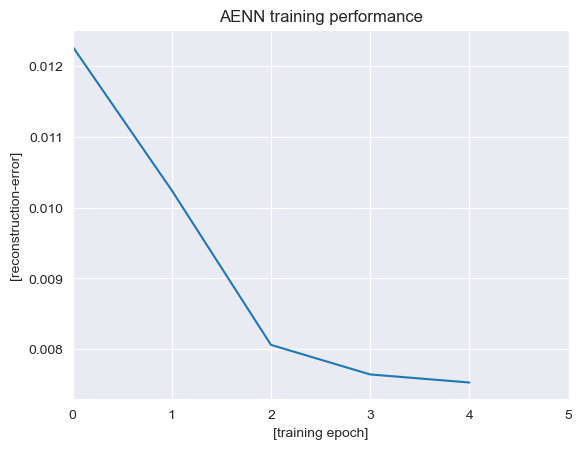

In [40]:
# plot the training progress
plt.plot(range(0, len(losses)), losses)
plt.xlabel('[training epoch]')
plt.xlim([0, len(losses)])
plt.ylabel('[reconstruction-error]')
#plt.ylim([0.0, 1.0])
plt.title('AENN training performance')

How does the reconstruction loss change as we progress in training our model? After 5 epochs, we can observe that our reconstruction loss already went down significantly and starts to converge nicely. This indicates that our network did a pretty good job in learning the structure and attributes of the journal entries.

But, from the plot we also observe that the model could probably be trained a couple more epochs as the trend of the reconstruction error still decreases for the last few epochs. In order to save time, we will continue the lab using a pre-trained model already trained by 20 epochs.

### Exercises:

Before we continue with the next notebook section it's time for some exercises:

>1. Set the `USE_CUDA` flag to `False` and re-start the training procedure. What impact do you observe in terms of training time needed for training a single epoch? Please, note that after altering the `USE_CUDA` flag you need to execute all successive cells starting from section 4.2. [5-10 min]
>2. Set the `dropout` probability to `0.8` (80%) and re-start the training procedure. What impact do you observe in terms of training performance / reconstruction loss? Please, note that after altering the `dropout` probability you need to execute all successive cells starting from section 4.2. [5-10 min]

## 6. Evaluating the Autoencoder Neural Network (AENN) Model

Now that we know how to train our autoencoder model, we will explore how we can use it to detect anomalies within the entire population of journal entries. Initially, we will start by loading a pre-trained model of 10 epochs and assess its reconstruction capability on the entire dataset. 

The pre-trained model is stored in the same directory as the lab notebook and can be loaded by executing the cell below: 

In [65]:
encoder_train

encoder(
  (encoder_L1): Linear(in_features=202, out_features=512, bias=True)
  (encoder_R1): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L2): Linear(in_features=512, out_features=256, bias=True)
  (encoder_R2): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L3): Linear(in_features=256, out_features=128, bias=True)
  (encoder_R3): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L4): Linear(in_features=128, out_features=64, bias=True)
  (encoder_R4): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L5): Linear(in_features=64, out_features=32, bias=True)
  (encoder_R5): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L6): Linear(in_features=32, out_features=16, bias=True)
  (encoder_R6): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L7): Linear(in_features=16, out_features=8, bias=True)
  (encoder_R7): LeakyReLU(negative_slope=0.4, inplace=True)
  (encoder_L8): Linear(in_features=8, out_features=4, bias=True)
  (encoder_R8): LeakyReLU(negat

In [41]:
# restore pretrained model checkpoint
encoder_model_name = "ep_5_encoder_model.pth"
decoder_model_name = "ep_5_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

<All keys matched successfully>

### 6.1 Assessment of the Pre-Trained Model

Once obtained, let's use the model to reconstruct the entire dataset:

In [42]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in evaluation mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

Now, let's assess its quality by calculating the reconstruction error over the entire dataset:

In [43]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = loss_function(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.item()))

[LOG 20240719-21:52:34] collected reconstruction loss of: 2107826/2107826 transactions
[LOG 20240719-21:52:34] reconstruction loss: 0.0075272359


Ok, nice. Comparing the overall reconstruction loss of the pre-trained model trained for **10 epochs** to the one we initially trained for **5 epochs** reveals, that the pre-trained model results in a significantly lower reconstruction error. We can therefore conclude that the pre-trained model outperforms our initial model in capturing the inherent characteristics of the journal entries.

### 6.2 Assessment of the Individual Transactions

Ok, now that we are convinced that the pre-trained model is of decent quality let's assess the individual journal entries of the dataset. To achieve this, we collect the reconstruction errors of each individual journal entry by executing the cell below:

In [44]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = loss_function(reconstruction[i], data[i]).item()

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individual reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))
        

[LOG 20240719-21:52:40] collected individual reconstruction loss of: 000000/2107826 transactions
[LOG 20240719-21:52:50] collected individual reconstruction loss of: 100000/2107826 transactions
[LOG 20240719-21:52:59] collected individual reconstruction loss of: 200000/2107826 transactions
[LOG 20240719-21:53:08] collected individual reconstruction loss of: 300000/2107826 transactions
[LOG 20240719-21:53:18] collected individual reconstruction loss of: 400000/2107826 transactions
[LOG 20240719-21:53:27] collected individual reconstruction loss of: 500000/2107826 transactions
[LOG 20240719-21:53:36] collected individual reconstruction loss of: 600000/2107826 transactions
[LOG 20240719-21:53:46] collected individual reconstruction loss of: 700000/2107826 transactions
[LOG 20240719-21:53:55] collected individual reconstruction loss of: 800000/2107826 transactions
[LOG 20240719-21:54:04] collected individual reconstruction loss of: 900000/2107826 transactions
[LOG 20240719-21:54:13] collec

Once we have collected individual reconstruction errors let's visualize them accordingly:

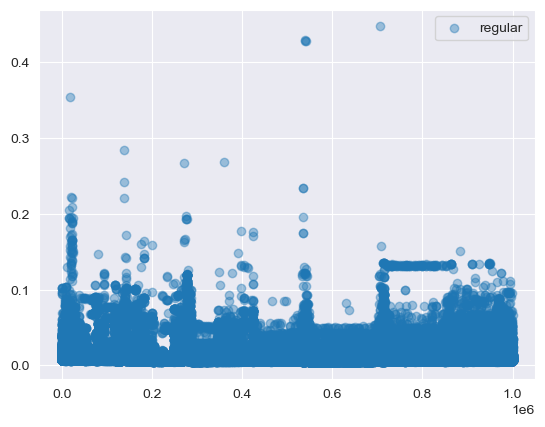

In [45]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# assign unique id to transactions
plot_data = np.column_stack((np.arange(len(reconstruction_loss_transaction)), reconstruction_loss_transaction))
dat = plot_data[:1000000]

# obtain regular transactions as well as global and local anomalies
# regular_data = plot_data[label == 'regular']
# global_outliers = plot_data[label == 'global']
# local_outliers = plot_data[label == 'local']

# plot reconstruction error scatter plot
ax.scatter(dat[:, 0], dat[:, 1], c='C0', alpha=0.4, marker="o", label='regular') # plot regular transactions
# ax.scatter(global_outliers[:, 0], global_outliers[:, 1], c='C1', marker="^", label='global') # plot global outliers
# ax.scatter(local_outliers[:, 0], local_outliers[:, 1], c='C2', marker="^", label='local') # plot local outliers

# add plot legend of transaction classes
ax.legend(loc='best')

The visualization reveals that the pre-trained model is able to reconstruct the majority of regular journal entries, while failing to do so, for the anomalous ones. As a result, the model reconstruction error can be used to distinguish both "global" anomalies (orange) and "local" anomalies (green) from the regular journal entries (blue).

To further investigate our observation and confirm the initial assumption, let's have a closer look into the journal entries exhibiting a "high" binary cross-entropy reconstruction error >= 0.1. We assume that these journal entries correspond to the "global" anomalies of the original dataset:

In [46]:

reconstruction_loss_transaction[0]

0.008066955022513866

In [98]:
ori_dataset['reconstruction_loss'] = reconstruction_loss_transaction

Let's now also have a closer look into the journal entries exhibiting a "medium" binary cross-entropy reconstruction error >= 0.02 and < 0.1. We assume that these journal entries mostly correspond to the "local" anomalies of the original dataset:

## 7. Optional Exercises

Please read ahead and only come back to these optional exercises if time permits.

**1. Train the autoencoder model from scratch** [15 mins]

First, change the number of training epochs `num_epochs` to **30** in the corresponding cell of section 5.1. Second, you might also want to try different learning rates other than the initial learning rate of **0.001** in the corresponding cell of section 4.3. Third, comment out the two lines in the first cell of section 6. where the pre-trained model is defined (under "restore pre-trained model checkpoint") as well as two lines where it is loaded (under "load trained models"). 

Please, note that after altering the number of training epochs in section 5.1 and/or the learning rate in section 4.3 you need to execute all successive cells starting from section 5.1 or 4.3.

**2. What would happen if we remove a few fully-connected layers?** [15 mins]

We designed a specific model for the lab because experiments show that the structure provided result in a good detection accuracy. Let's see how the reconstruction performance change if we would **remove several of the hidden layers**. First, adjust the encoder and decoder model definitions in section 4.2 accordingly (you may want to use the code snippets shown below). Then, follow all the instructions for training from scratch.

Please, note that after altering the encoder and / or decoder network architecture in section 4.2 you need to execute all successive cells starting from section 4.2.

In [ ]:
# implementation of the shallow encoder network 
# containing only a single layer
class shallow_encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        # specify layer 1 - in 618, out 3
        self.encoder_L1 = nn.Linear(in_features=ori_subset_transformed.shape[1], out_features=3, bias=True) # add linearity 
        nn.init.xavier_uniform_(self.encoder_L1.weight) # init weights according to [9]
        self.encoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]
        
    def forward(self, x):

        # define forward pass through the network
        x = self.encoder_R1(self.encoder_L1(x)) # don't apply dropout to the AE bottleneck

        return x

In [ ]:
# implementation of the shallow decoder network 
# containing only a single layer
class shallow_decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        # specify layer 1 - in 3, out 618
        self.decoder_L1 = nn.Linear(in_features=3, out_features=ori_subset_transformed.shape[1], bias=True) # add linearity 
        nn.init.xavier_uniform_(self.decoder_L1.weight)  # init weights according to [9]
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True) # add non-linearity according to [10]

    def forward(self, x):

        # define forward pass through the network
        x = self.decoder_R1(self.decoder_L1(x)) # don't apply dropout to the AE output
        
        return x

**3. Explore the latent space representation** [15 min]

In a real world scenario it is usually beneficial to visualize the data manifolds to:

> 1. determine if the autoencoder learned a meaningful representation; and,
> 2. obtain an impression of the structural characteristics and dependencies in the data.

To achieve this, we will propagate the data through the trained model and capture for each transaction the respective representation in the latent space as referred to as "embeddings" (the activation pattern of each journal entry at the bottleneck neurons). 

Therefore, we intentionally chose a bottleneck layer comprised of 3 neurons. This provides us the ability to visualize the distinctive activation pattern using the 3d plotting capabilities of Pythons matplotlib library. In the subsequent cells we already prepared a plotting function that draws a 3d scatter plot of the latent space representation of each transaction at a particular epoch.

In [ ]:
# plot latent space representation of all samples given latent variable and label class
def plot_latent_space(latent_variable, label, epoch):
    """ Plots latent space activations as a 3d scatter plot at particular epoch
    :param latent_space: activations of latent space
    :param label: 1-d array of labels defining type of anomaly
    :param epoch: training epoch
    """
    # prepare plot
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(30, 45)

    # set axis paramaters of subplot
    ax.grid(linestyle='dotted')
    
    # set label and title details
    ax.set_xlabel(r'activation [$z_1$]', weight='normal', fontsize=12)
    ax.set_ylabel(r'activation [$z_2$]', weight='normal', fontsize=12)
    ax.set_zlabel(r'activation [$z_3$]', weight='normal', fontsize=12)
    plt.title('latent space activations at epoch ' + str(epoch), fontsize=12)

    # plot regular transactions
    regular = latent_variable[np.where(label == 'regular')]
    ax.scatter(regular[:, 0], regular[:, 1], regular[:, 2], c='C0', alpha=0.4, marker="o")

    # plot first order anomalous transactions
    anomalies_1 = latent_variable[np.where(label == 'global')]
    ax.scatter(anomalies_1[:, 0], anomalies_1[:, 1], anomalies_1[:, 2], c='C1', s=100, marker="^")

    # plot second order anomalous transactions
    anomalies_2 = latent_variable[np.where(label == 'local')]
    ax.scatter(anomalies_2[:, 0], anomalies_2[:, 1], anomalies_2[:, 2], c='C2', s=100, marker="^")

However, before plotting the embeddings we load the model of the shallow autoencoder network you have been asked to train in exercise 7.2 of the optional exercises. Since we are interested on the latent space representation of each transaction we only need to load the pre-trained encoder part of the autoencoder (ignoring the decoder part) and propagate all transactions through it.

The function below will accomplish these steps for a given pre-trained encoder model.

In [ ]:
# extract latent space representation of all samples given the name of encoder model to be loaded
def get_latent_space(encoder_model_name):
    ''' Extracts the latent space representation
    :param encoder_model_name: file name of the pretrained encoder model
    :return: latent space representation
    '''
    # init training network classes / architectures
    encoder_eval = encoder()

    # load trained models
    encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))

    # convert encoded transactional data to torch Variable
    data = autograd.Variable(torch_dataset)

    # set networks in training mode (don't apply dropout)
    encoder_eval.eval()

    # extract encoded latent space representation
    latent_variable = encoder_eval(data).data.numpy()
    
    return latent_variable

Now let's check how the latent space representation "embeddings" of the individual transactions changes with progressing training epochs. In order to do so, you can load any checkpoint of a particular training epoch and visualize the latent representations you want to have a look at using the code snipped below. 

If you didn't find the time to accomplish exercise 7.2 you may want to plot the embeddings using the pre-trained model we prepared for this lab as stated in the cell below. This will also give you an idea of the transactional manifolds learned by the autoencoder network.

In [ ]:
# determine epoch of model to be evaluated
eval_epoch = 5

# collect latent space representation at a certain epochs 
z_representation = get_latent_space(encoder_model_name='ep_{}_encoder_model.pth'.format(eval_epoch))

# plot the latent space at a particular epoch
plot_latent_space(z_representation, label, epoch=eval_epoch)

Finally, you may want to save the content of the lab to your local machine. Therefore, please execute the cell below to retrieve an archived version of your current lab content.

In [ ]:
!tar -czf GTC_2018_Lab.tar.gz *

You may also want to execute the content of your lab outside of the jupyter notebook environment e.g. on compute node or server. The cell below converts the lab notebook into a standalone and executable python script.

In [ ]:
!jupyter nbconvert --to script GTC_2018_Lab.ipynb

## 8. Lab Summary

In this lab, we presented a step by step implementation of an autoencoder deep neural network based methodology to detect anomalies in financial data. The degree of a financial transaction "abnormity" is evaluated based on its respective reconstruction error. The code provided in this lab can be tailored to meet more complex fraud detection scenarios and datasets.

## 9. Post-Lab Exercises

We recommend you to try the following exercises after the lab:

**1. Evaluation of shallow and deep autoencoder models** 

Try to train and evaluate further (shallow and deeper) autoencoder models (by removing and adding of fully-connected layers). Analyse the performance in terms of training time and reconstruction error.

**2. Comparison to other dimensionality reduction techniques**

Try using other dimensionality reduction techniques such as principal component analysis, non-negative matrix factorization or sparse coding and compare the detected anomalies with the ones detected by the autoencoder.

**3. Review of additional autoencoder concepts**

Try using other autoencoder architectures such as variational [13] or adversarial [14] autoencoder and compare the results with the autoencoder architecture implemented above.

## 10. References

Major elements of the lab content are inspired by the publication "Detection of Anomalies in Large Scale Accounting Data using Deep Autoencoder Networks", of M. Schreyer, T. Sattarov, D. S. Borth, A. Dengel, and B. Reimer, 2017 (arXiv preprint available under: https://arxiv.org/abs/1709.05254).

[1] ACFE, "Report to the Nations on Occupational Fraud and Abuse", The 2016 Global Fraud Study, Association of Certified Fraud Examiners (ACFE), 2016.

[2] J. T. Wells, "Corporate Fraud Handbook: Prevention and Detection", John Wiley & Sons, 2017.

[3] PwC, "Pulling Fraud Out of the Shadows", The Global Economic Crime and Fraud Survey 2018, PricewaterhouseCoopers LLP, 2018.

[4] S. Markovitch, P. Willmott, "Accelerating the digitization of business processes", McKinsey & Company (2014) 1–5.

[5] SAP, SAP Global Corporate Affairs, Corporate Factsheet 2017, 2017.

[6] E. A. Lopez-Rojas , A. Elmir, and S. Axelsson, "PaySim: A financial mobile money simulator for fraud detection", In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus, 2016.

[7] G. E. Hinton, and R. R. Salakhutdinov, "Reducing the dimensionality of data with neural networks", science 313, no. 5786: 504-507, 2006.

[8] N. Srivastava, G. E. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A simple way to prevent neural networks from overfitting", The Journal of Machine Learning Research, 15(1), 1929-1958, 2014.

[9] X. Glorot and Y. Bengio, "Understanding the difficulty of training deep feedforward neural networks", Proceedings of the 13th International Conference on Artificial Intelligence and Statistics (AISTATS), 9:249–256, 2010.

[10] B. Xu, N. Wang, T. Chen, and M. Li, "Empirical Evaluation of Rectified Activations in Convolution Network", ICML Deep Learning Workshop, pages 1–5, 2015.

[11] D. P. Kingma and J. Ba, "Adam: A method for stochastic optimization", International Conference on Learning Representations (ICLR). 2015.

[12] G. E. Hinton, N. Srivastava, A. Krizhevsky, I. Sutskever, R. R. Salakhutdinov. "Improving neural networks by preventing co-adaptation of feature detectors", Technical Report, 2012.

[13] D. P. Kingma, M. Welling. "Auto-encoding variational bayes", arXiv preprint arXiv:1312.6114, 2013.

[14] Makhzani, A., Shlens, J., Jaitly, N., Goodfellow, I., & Frey, B., "Adversarial autoencoders", arXiv preprint arXiv:1511.05644, 2015.
